In [14]:
import numpy as np
import matplotlib as plt
import graphviz
import random

In [15]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_graph(root):
    graph = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in graph, create a rectangular ('record') node for it
        graph.node(name = uid, label = "{%s | data = %.4f | grad = %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            graph.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            graph.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #connect n1 to the op node of n2
        graph.edge(str(id(n1)), str(id(n2)) + n2._op)

    return graph

In [16]:
class Value:
    def __init__(self, data, label=None, _prev=(), _op=None, grad=0):
        self.data = data
        self.label = label
        self._prev = _prev
        self._op = _op
        self.grad = grad
        self._backwards = lambda: None

    def __repr__(self):
        return f"Value: {self.data}"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, _prev=(self, other), _op='+')

        def backwards():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backwards = backwards

        return out

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, _prev=(self, other), _op='*')

        def backwards():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backwards = backwards
        
        return out

    def __rmul__(self, other):
        return self * other

    def __pow__(self, power):
        # Only works when power is int/float for now
        out = Value(self.data ** power, _prev=(self,), _op=f"**{power}")

        def backwards():
            self.grad += power * self.data ** (power - 1) * out.grad

        out._backwards = backwards
        
        return out

    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data / other.data, _prev=(other, self), _op='/')
        
        def backwards():
            self.grad += 1 / other.data * out.grad
            other.grad += (-self.data) * (other.data ** -2)
        
        out._backwards = backwards
        
        return out

    def __rtruediv__(self, other):
        return self / other
    
    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)
        
    
    def exp(self):
        out = Value(np.exp(self.data), _prev=(self,), _op = 'exp')

        def backwards():
            # Since f'(e^x) is e^x
            self.grad += out.data * out.grad

        out._backwards = backwards

        return out

    def leakyRelu(self):
        return self if self.data >= 0 else self*0.01

    def tanh(self):
        exp_val = (self * 2).exp()
        out = (exp_val - 1) / (exp_val + 1)

        return out
        
    def get_order(self):
        order = [self]
        visited = {self}
        queue_idx = 0
        
        while queue_idx < len(order):
            for child in order[queue_idx]._prev:
                if child not in visited:
                    visited.add(child)
                    order.append(child) 
            queue_idx += 1
                

        return order

    def backwards(self):
        order = self.get_order()
        self.grad = 1.0
        for node in order:
            node._backwards()

In [17]:
class Neuron:
    def __init__(self, numInputs):
        self.weights =  [Value(random.uniform(1,-1)) for _ in range(numInputs)]
        self.bias = Value(random.uniform(1, -1))

    def __repr__(self):
        return f"Neuron:\n\tWeights: {self.weights} \n\tBias: {self.bias}\n"

    def __call__(self, inputs):
        # call to run neurons weights and biases on input x
        weightInputPair = zip(self.weights, inputs)
        #print(list(weightInputPair))
        act = sum((w * x for w, x in weightInputPair ), self.bias)
        # Activation function
        out = act.leakyRelu()
        return out

    def parameters(self):
        return self.weights + [self.bias]

In [18]:
class Layer:
    def __init__(self, numInputs, numNeurons):
        self.neurons = [Neuron(numInputs) for _ in range(numNeurons)]

    def __repr__(self):
        return f"Layer:\n {self.neurons}"

    def __call__(self, inputs):
        out = []
        for n in self.neurons:
            out.append(n(inputs))
            
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [param for n in self.neurons for param in n.parameters()]


In [19]:
class MLP:
    def __init__(self, numInputs, dims):
        mlpSize = [numInputs] + dims
        layers = []
        for i in range(len(mlpSize) - 1):
            layer = Layer(mlpSize[i], mlpSize[i + 1])
            layers.append(layer)
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            # calculate inputs to the next layer for each layer
            x = layer(x)

        return x
    
    def __repr__(self):
        return "MLP of \n[" + ", \n".join(str(layer) for layer in self.layers) + "]"

    def parameters(self):
        return [param for layer in self.layers for param in layer.parameters()]

In [76]:
testMLP = MLP(2, [2, 2, 1])

In [84]:
inputs = [[Value(2.0), Value(3.0)], [Value(-1.0), Value(4.0)]] 
targets = [1.0, -1.0]

In [150]:
for i in range(20):
    preds = [testMLP(input) for input in inputs]
    loss = sum((pred - target) ** 2 for pred, target in zip(preds, targets))
    #loss += sum((p**2)**0.5 for p in testMLP.parameters()) * 0.01
    for p in testMLP.parameters():
        p.grad = 0.0
    loss.backwards()
    # Reset grads
    for p in testMLP.parameters():
        p.data += -0.05 * p.grad
        #param.grad = 0.0

    print(i, loss)

0 Value: 6.226549603182457e-06
1 Value: 5.834236286096514e-06
2 Value: 5.466608619763596e-06
3 Value: 5.122116337414254e-06
4 Value: 4.799306247367143e-06
5 Value: 4.496816180581827e-06
6 Value: 4.213369313110491e-06
7 Value: 3.947768840479832e-06
8 Value: 3.698892982398391e-06
9 Value: 3.4656902974783157e-06
10 Value: 3.2471752888953644e-06
11 Value: 3.0424242830943315e-06
12 Value: 2.8505715646917863e-06
13 Value: 2.6708057517871254e-06
14 Value: 2.5023663968442653e-06
15 Value: 2.3445407992069658e-06
16 Value: 2.196661016158624e-06
17 Value: 2.0581010602673027e-06
18 Value: 1.928274271453955e-06
19 Value: 1.8066308529878332e-06


In [151]:
preds = [testMLP(input) for input in inputs]
preds

[Value: 0.9998775021821762, Value: -0.9987047587692405]

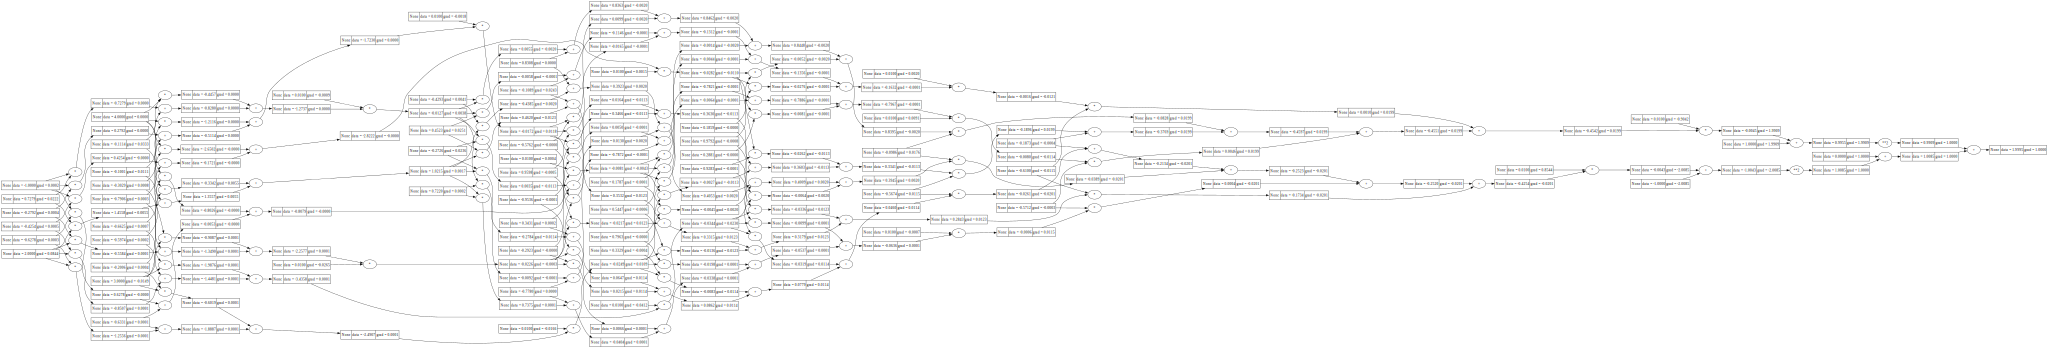

In [68]:
draw_graph(loss)